In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pca-clustering-training/pca_clustering_training.csv
/kaggle/input/preprocessed-data/pca_clustering_testing.csv
/kaggle/input/preprocessed-data/pca_clustering_training.csv
/kaggle/input/preprocessed-data/merge_auxiliary_data_train.csv
/kaggle/input/preprocessed-data/merge_auxiliary_data_test.csv
/kaggle/input/clustering/clustering.py
/kaggle/input/preprocessing-merge/preprocessing_merge.py
/kaggle/input/final-models/regressor_rf_updated_v1.pkl
/kaggle/input/final-models/regressor_rf_updated_v3.pkl
/kaggle/input/final-models/regressor_xgboost_updated.pkl
/kaggle/input/final-models/regressor_rf_updated_v2.pkl
/kaggle/input/cs5228-202223-s2-location-location-location/train.csv
/kaggle/input/cs5228-202223-s2-location-location-location/test.csv
/kaggle/input/cs5228-202223-s2-location-location-location/auxiliary-data/sg-commerical-centres.csv
/kaggle/input/cs5228-202223-s2-location-location-location/auxiliary-data/sg-gov-markets-hawker-centres.csv
/kaggle/input/cs5228-202223-s2-

In [8]:
import sys
sys.path.append("/kaggle/input/preprocessing-merge/")
sys.path.append("/kaggle/input/preprocessing-train-test/")
sys.path.append("/kaggle/input/clustering/")

from preprocessing_merge import *
from preprocessing_train_test import *
from clustering import *

In [9]:
%reload_ext autoreload
%autoreload 2

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', 100)  # 设置显示100列
pd.set_option('display.max_rows', 100)   # 设置显示100行

In [10]:
file_path_train = "/kaggle/input/preprocessed-data/merge_auxiliary_data_train.csv"
file_path_test = "/kaggle/input/preprocessed-data/merge_auxiliary_data_test.csv"
file_path_clustering_train = "/kaggle/input/preprocessed-data/pca_clustering_training.csv"
file_path_clustering_test = "/kaggle/input/preprocessed-data/pca_clustering_testing.csv"

train_gdf = pd.read_csv(file_path_train)
test_gdf = pd.read_csv(file_path_test)

print("train dataset shape: ", train_gdf.shape)
print("test dataset shape: ",test_gdf.shape)

pca_cluster_df_training = pd.read_csv(file_path_clustering_train)
pca_cluster_df_testing = pd.read_csv(file_path_clustering_test)

train_gdf_updated = pd.concat([train_gdf, pca_cluster_df_training.reset_index(drop=True)], axis=1)
test_gdf_updated = pd.concat([test_gdf, pca_cluster_df_testing.reset_index(drop=True)], axis=1)

print("train dataset shape: ", train_gdf_updated.shape)
print("test dataset shape: ",test_gdf_updated.shape)

train dataset shape:  (431732, 55)
test dataset shape:  (107934, 54)
train dataset shape:  (431732, 58)
test dataset shape:  (107934, 57)


In [28]:
# Best XGBoost model on a single 70:30 split
X_train, X_test, y_train, y_test = train_test_split(train_gdf_updated.loc[:, ~train_gdf_updated.columns.isin(["resale_price"])], train_gdf_updated["resale_price"], test_size=0.3, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_df, test_df = preprocess_train_test(train, test)
x_train, y_train = train_df.drop(columns=["resale_price"], errors='ignore'), train_df["resale_price"]
x_valid, y_valid = test_df.drop(columns=["resale_price"], errors='ignore'), test_df["resale_price"]

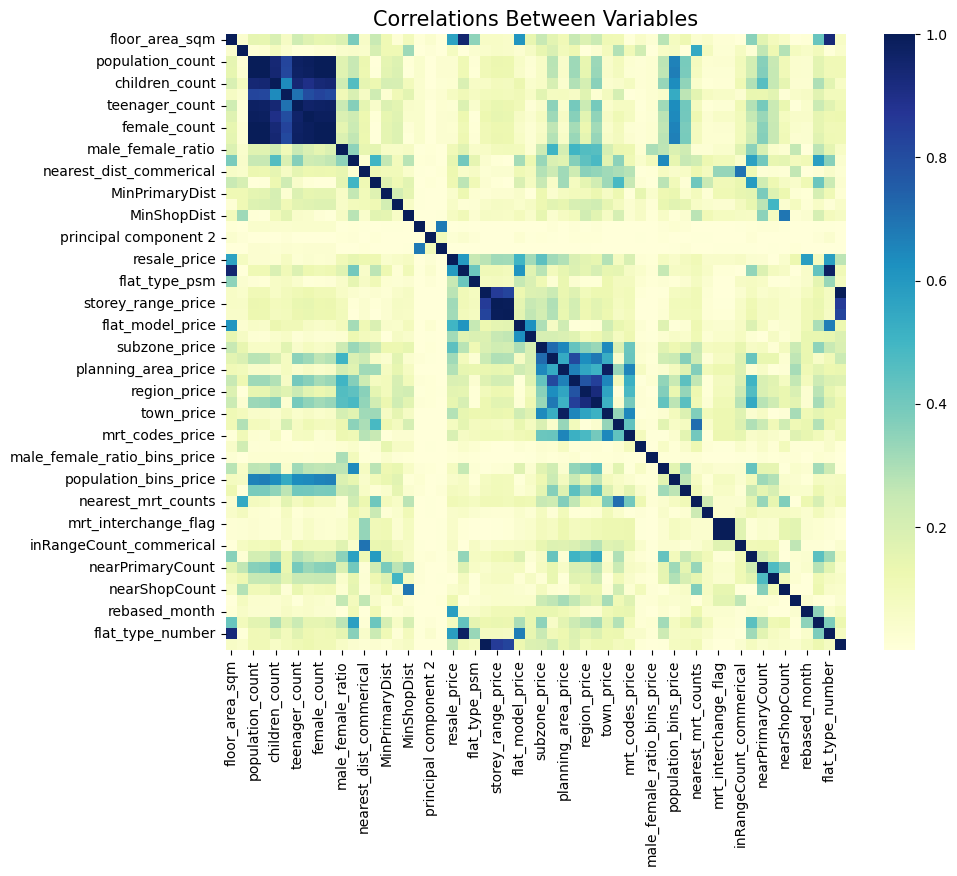

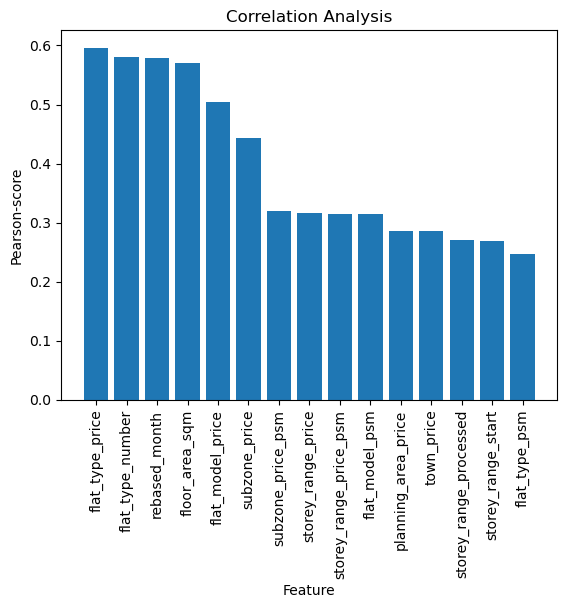

In [30]:
def visualize(dataset: DataFrame):
    # Visualizing the correlations between numerical variables
    plt.figure(figsize=(10, 8))
    sns.heatmap(abs(dataset.corr()), cmap="YlGnBu")
    plt.title("Correlations Between Variables", size=15)
    plt.show()

float_cols = list(train_df.select_dtypes("float").columns)
int_cols = list(train_df.select_dtypes("int").columns)
total_cols = float_cols + int_cols
total_cols_filter = [i for i in total_cols if "id" not in i and i not in ["latitude", "longitude"]]

visualize(train_df[total_cols_filter])

a = calculateTopCorrelation(train_df[total_cols_filter])[1:16]
labels = a['Columns']
values = a['Pearson-score']

fig, ax = plt.subplots()
ax.bar(labels, values)

ax.set_xlabel('Feature')
ax.set_ylabel('Pearson-score')
ax.set_title('Correlation Analysis')
ax.set_xticklabels(labels, fontsize=10, rotation=90)

# 显示图形
plt.show()

In [6]:
columns_preprocess = ['floor_area_sqm', 'distance_to_mrt', 'nearest_mrt_counts',
       'mrt_lrt_links', 'mrt_interchange_flag', 'mrt_interchange_count',
       'population_count', 'adult_count', 'children_count',
       'senior_citizen_count', 'teenager_count', 'young_adult_count',
       'female_count', 'male_count', 'male_female_ratio',
       'adult_children_ratio', 'nearest_dist_commerical',
       'inRangeCount_commerical', 'nearest_dist_market', 'inRangeCount_market',
       'MinPrimaryDist', 'nearPrimaryCount', 'MinSecDist', 'nearSecondCount',
       'MinShopDist', 'nearShopCount', 'principal component 1',
       'principal component 2', 'DBSCAN_cluster', 'resale_price',
       'rebased_month', 'remaining_lease', '1-room', '2-room', '3-room',
       '4-room', '5-room', 'executive', 'multi-generation', 'flat_type_price',
       'flat_type_psm', 'flat_type_number', 'storey_range_start',
       'storey_range_processed', 'storey_range_price',
       'storey_range_price_psm', 'flat_model_price', 'flat_model_psm',
       'grid_price', 'grid_price_psm', 'subzone_price', 'subzone_price_psm',
       'planning_area_price', 'planning_area_price_psm', 'region_price',
       'region_price_psm', 'mrt_type_price', 'mrt_codes_price',
       'distance_to_mrt_bins_price', 'male_female_ratio_bins_price',
       'adult_children_ratio_bins_price', 'population_bins_price',
       'type_commerical_price']

print([i for i in columns_preprocess if "price" in i])

['resale_price', 'flat_type_price', 'storey_range_price', 'storey_range_price_psm', 'flat_model_price', 'grid_price', 'grid_price_psm', 'subzone_price', 'subzone_price_psm', 'planning_area_price', 'planning_area_price_psm', 'region_price', 'region_price_psm', 'mrt_type_price', 'mrt_codes_price', 'distance_to_mrt_bins_price', 'male_female_ratio_bins_price', 'adult_children_ratio_bins_price', 'population_bins_price', 'type_commerical_price']


In [ ]:
# Best XGBoost model on a single 70:30 splitxw
# Here we use a train_gdf dataset instead of train_gdf_updated as above as we tried the above updated dataset and did not yield good performance.
X_train, X_test, y_train, y_test = train_test_split(train_gdf.loc[:, ~train_gdf.columns.isin(["resale_price"])], train_gdf["resale_price"], test_size=0.3, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_df, test_df = preprocess_train_test(train, test)
x_train, y_train = train_df.drop(columns=["resale_price"], errors='ignore'), train_df["resale_price"]
x_valid, y_valid = test_df.drop(columns=["resale_price"], errors='ignore'), test_df["resale_price"]

regressor = xgb.XGBRegressor(n_estimators=2000, max_depth=6, min_child_weight=1.3, reg_alpha=1.6, reg_lambda=1.5, subsample=1, n_jobs=3).fit(x_train, y_train)
y_train_predict = regressor.predict(x_train)
y_valid_predict = regressor.predict(x_valid)

print(mean_absolute_error(y_train, y_train_predict))
print(mean_absolute_error(y_valid, y_valid_predict))
print(mean_squared_error(y_train, y_train_predict))
print(mean_squared_error(y_valid, y_valid_predict))

In [ ]:
# Best Random Forest model on a single 70:30 split
X_train, X_test, y_train, y_test = train_test_split(train_gdf.loc[:, ~train_gdf.columns.isin(["resale_price"])], train_gdf["resale_price"], test_size=0.3, random_state=42)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
train_df, test_df = preprocess_train_test(train, test)
x_train, y_train = train_df.drop(columns=["resale_price"], errors='ignore'), train_df["resale_price"]
x_valid, y_valid = test_df.drop(columns=["resale_price"], errors='ignore'), test_df["resale_price"]

regressor_rf = RandomForestRegressor(n_estimators=500, max_depth=24, max_features=0.6, min_samples_split=0.00001, min_samples_leaf=0.00001, n_jobs=3).fit(x_train, y_train)
y_train_predict_rf = regressor_rf.predict(x_train)
y_valid_predict_rf= regressor_rf.predict(x_valid)

print(mean_absolute_error(y_train, y_train_predict_rf))
print(mean_absolute_error(y_valid, y_valid_predict_rf))
print(mean_squared_error(y_train, y_train_predict_rf))
print(mean_squared_error(y_valid, y_valid_predict_rf))

In [ ]:
# Final Ensemble Prediction
y_train_final = np.mean([y_train_predict, y_train_predict_rf], axis=0)
y_valid_final = np.mean([y_valid_predict, y_valid_predict_rf], axis=0)

print(mean_absolute_error(y_train, y_train_final))
print(mean_absolute_error(y_valid, y_valid_final))
print(mean_squared_error(y_train, y_train_final))
print(mean_squared_error(y_valid, y_valid_final))

In [ ]:
# pickle.dump(regressor, open("/kaggle/working/regressor_xgboost.pkl", "wb"))
# pickle.dump(regressor_rf, open("/kaggle/working/regressor_rf.pkl", "wb"))

# Full training and testing

Implement the above code on full training and testing data i.e. Train on full training dataset, and generate predictions for test dataset for kaggle submission.

In [11]:
train_gdf = pd.read_csv('/kaggle/input/preprocessed-data/merge_auxiliary_data_train.csv')
test_gdf = pd.read_csv('/kaggle/input/preprocessed-data/merge_auxiliary_data_test.csv')

In [14]:
# Note the model was previously saved in /kaggle/working as mentioned above 
# -> as session has stopped and paused, reuploaded the files in /kaggle/input/final-models
regressor_xgboost = pickle.load(open("/kaggle/input/final-models/regressor_xgboost_updated.pkl", "rb"))
regressor_randomforest = pickle.load(open("/kaggle/input/final-models/regressor_rf_updated_v3.pkl", "rb"))

In [26]:
# # Fit models on full Train dataframe
train_df_all, test_df_all = preprocess_train_test(train_gdf, test_gdf)
x_train = train_df_all.drop(columns=["resale_price"], errors='ignore')
# print("Fitting xgboost_model")
# regressor_xgboost.fit(x_train, train_df_all['resale_price'])
# print("Fitting random forest model")
# regressor_randomforest.fit(x_train, train_df_all['resale_price'])

# Performing prediction
y_train_predict = regressor_xgboost.predict(x_train)
y_train_predict2 = regressor_randomforest.predict(x_train)
res_train = pd.DataFrame(np.mean([y_train_predict, y_train_predict2], axis=0), columns=['Predicted'])
print(mean_absolute_error(train_df_all['resale_price'], res_train))

8435.308996013197


In [ ]:
# # Save updated models
# pickle.dump(regressor_backup, open("regressor_xgboost_updated.pkl", "wb"))
# pickle.dump(regressor_v2_backup, open("regressor_rf_updated.pkl", "wb"))

In [27]:
# Generate predictions for full test dataframe
x_test = test_df_all.copy()
y_test_predict = regressor_xgboost.predict(x_test)
y_test_predict2 = regressor_randomforest.predict(x_test)
res_test = pd.DataFrame(np.mean([y_test_predict, y_test_predict2], axis=0), columns=['Predicted'])
res2 = res_test.reset_index().rename(columns={'index':'Id'})
res2.to_csv('res2.csv', index=False) # This is the dataframe, submitted to kaggle that generate the best scores
display(res2.head())

,Id,Predicted
0,0,183135.023560
1,1,305134.482855
2,2,124111.416164
3,3,311681.167836
4,4,319517.585245


# Feature Importance Plot

These are the feature importance plot for the latest best model.

In [15]:
# Note the model was previously saved in /kaggle/working as mentioned above 
# -> as session has stopped and paused, reuploaded the files in /kaggle/input/final-models
regressor_xgboost = pickle.load(open("/kaggle/input/final-models/regressor_xgboost_updated.pkl", "rb"))
regressor_randomforest = pickle.load(open("/kaggle/input/final-models/regressor_rf_updated_v3.pkl", "rb"))

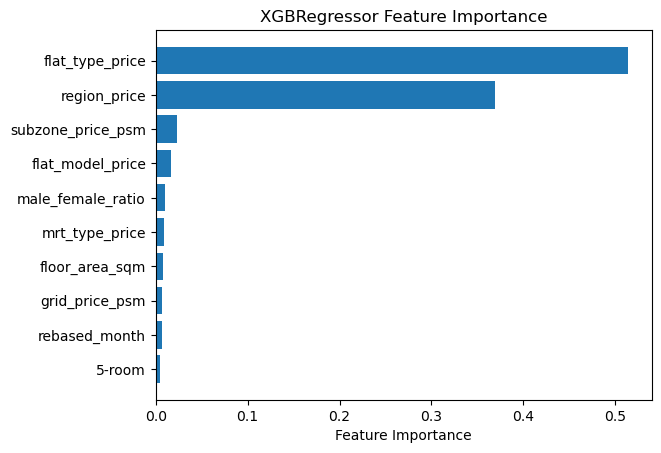

In [16]:
# XGBoost Feature Importance Plot
feature_impotance_df = pd.DataFrame({"Features":regressor_xgboost.get_booster().feature_names, "Feature Importance":regressor_xgboost.feature_importances_})
feature_impotance_df = feature_impotance_df.set_index("Features", inplace=False)
feature_impotance_df_filter = feature_impotance_df.sort_values("Feature Importance", ascending=False)[:10]

fig, ax = plt.subplots()
y_pos = np.arange(len(feature_impotance_df_filter.index))
ax.barh(y_pos, feature_impotance_df_filter["Feature Importance"], align='center')
ax.set_yticks(y_pos, labels=feature_impotance_df_filter.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('XGBRegressor Feature Importance')

plt.show()

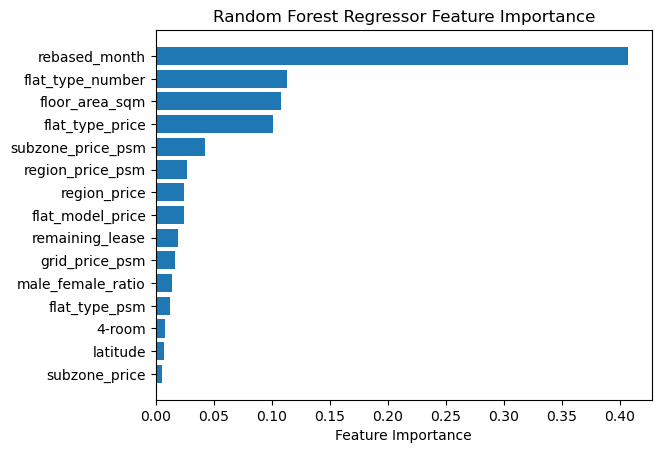

In [28]:
feature_impotance_df = pd.DataFrame({"Features":regressor_randomforest.feature_names_in_, "Feature Importance":regressor_randomforest.feature_importances_})
feature_impotance_df = feature_impotance_df.set_index("Features", inplace=False)
feature_impotance_df_filter = feature_impotance_df.sort_values("Feature Importance", ascending=False)[:15]

fig, ax = plt.subplots()
y_pos = np.arange(len(feature_impotance_df_filter.index))
ax.barh(y_pos, feature_impotance_df_filter["Feature Importance"], align='center')
ax.set_yticks(y_pos, labels=feature_impotance_df_filter.index)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Feature Importance')
ax.set_title('Random Forest Regressor Feature Importance')

plt.show()